In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
aapl = pd.read_csv('AAPL_CLOSE', index_col='Date', parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE', index_col='Date', parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE', index_col='Date', parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE', index_col='Date', parse_dates=True)

In [4]:
stocks = pd.concat([aapl, cisco, ibm, amzn], axis=1)
stocks.columns = ['aapl', 'cisco', 'ibm', 'amzn']

In [5]:
stocks.pct_change(1).mean()

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [6]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


In [7]:
stocks.pct_change(1).head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.019324,-0.004079,-0.008490
2012-01-05,0.011102,-0.003686,-0.004743,0.000563
2012-01-06,0.010454,-0.003700,-0.011481,0.028152
2012-01-09,-0.001586,0.006366,-0.005204,-0.022178


In [9]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


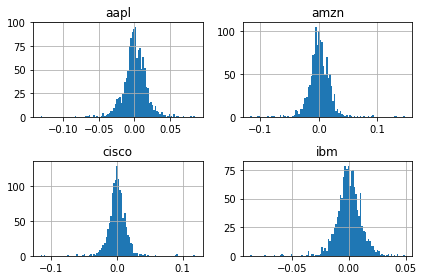

In [10]:
log_ret.hist(bins=100)
plt.tight_layout()

In [11]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

In [13]:
log_ret.cov() * 252

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [14]:
print(stocks.columns)

Index([u'aapl', u'cisco', u'ibm', u'amzn'], dtype='object')


In [29]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    weights = np.array(np.random.random(4))
    weights = weights/weights.sum() 
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]


In [31]:
sharpe_arr.max()

1.0303260551271067

In [32]:
sharpe_arr.argmax()

1420

In [37]:
all_weights[1420,:]
max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

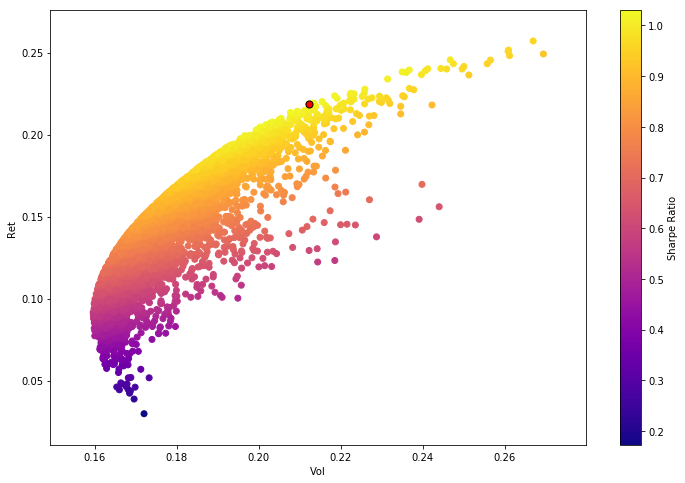

In [38]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Vol')
plt.ylabel('Ret')
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

In [41]:
def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [40]:
from scipy.optimize import minimize

In [42]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [43]:
def check_sum(weights):
    return np.sum(weights) - 1

In [45]:
cons = ({'type': 'eq', 'fun': check_sum})

In [46]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [47]:
init_guess = [0.25,0.25,0.25,0.25]

In [50]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [51]:
opt_results

     fun: -1.030716870334955
     jac: array([  5.64455986e-05,   4.18275595e-05,   3.39921728e-01,
        -4.45097685e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([  2.66289778e-01,   2.04189819e-01,   9.24621165e-17,
         5.29520404e-01])

In [52]:
opt_results.x

array([  2.66289778e-01,   2.04189819e-01,   9.24621165e-17,
         5.29520404e-01])

In [53]:
get_ret_vol_sr(opt_results.x)

array([ 0.21885915,  0.21233683,  1.03071687])

In [54]:
frontier_y = np.linspace(0,0.3, 100)

In [55]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [57]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun': check_sum}, 
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0]-possible_return}
           )
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])

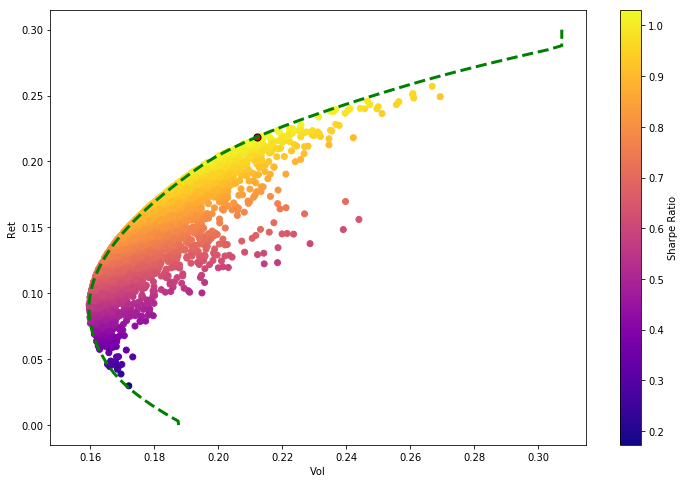

In [58]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Vol')
plt.ylabel('Ret')
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)